### Importing the modules

In [1]:
import cv2
from scipy import ndimage
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
import os

from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.morphology import convex_hull_image

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data
from skimage import measure

import matplotlib.pyplot as plt
from matplotlib import cm

### Load a Reference Image

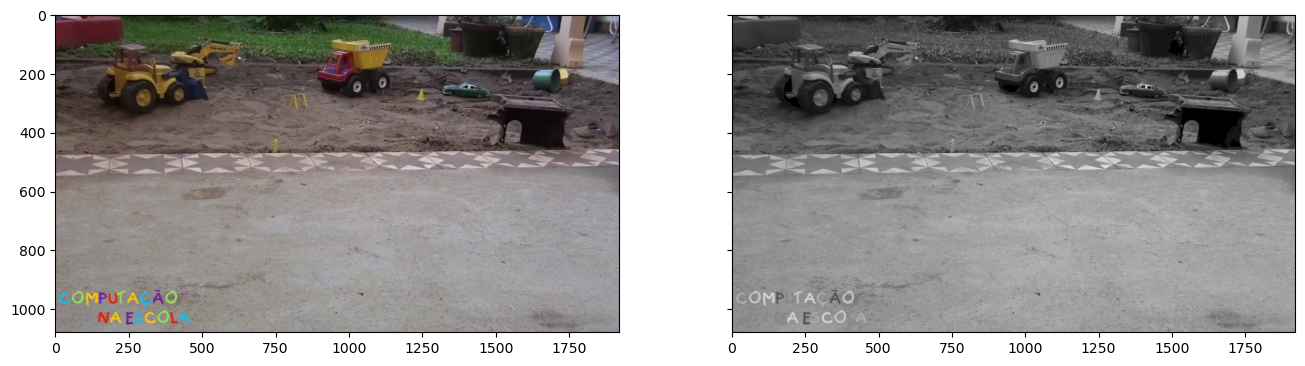

In [2]:
# Load the image in color (OpenCV standard = BGR)
ref_orig = cv2.imread("data/ref.png", cv2.IMREAD_COLOR)
# Convert to RGB
ref_orig = cv2.cvtColor(ref_orig, cv2.COLOR_BGR2RGB)

# Load the image in grayscale
ref_gray = cv2.imread("data/ref.png", cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(ref_orig)
ax[1].imshow(ref_gray, 'gray')

### List of Imagens to be evaluated

In [3]:
img = os.listdir("data/im")

In [4]:
def Img_Proc(image, thresh, kernel_open, kernel_close, show_color = False, show_diff = False, 
         show_tresh = False, show_open = False, show_close = False, show_mask = True, save_lim = False):
    
    
    # Load the image in color (OpenCV standard = BGR)
    orig = cv2.imread("data/im/" + image, cv2.IMREAD_COLOR)

    # Convert to RGB
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # Load the image in grayscale
    gray = cv2.imread("data/im/" + image, cv2.IMREAD_GRAYSCALE)

    # Show the images
    if show_color == True:
        fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
        ax = axes.ravel()
        ax[0].imshow(orig)
        ax[1].imshow(gray, 'gray')


    # Calculate the absolute difference between two images
    change = cv2.absdiff(gray, ref_gray)

    # Show the diference between the images
    if show_diff == True:
        plt.figure(figsize = (12,10))
        plt.imshow(change, 'gray')

    # Threshold
    mode = eval('cv2.THRESH_BINARY')
    th, dst = cv2.threshold(change, thresh, 255,mode)

    # Show the threshold effect
    if show_tresh == True:
        plt.figure(figsize = (12,10))
        plt.imshow(masked, 'gray')

    # Opening Kernel
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel_open)

    # Show the opening kernel effect
    if show_open == True:
        plt.figure(figsize = (12,10))
        plt.imshow(opening, 'gray')

    # Closing kernal
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)

    # Show the closing kernel effect
    if show_close == True:
        plt.figure(figsize = (12,10))
        plt.imshow(closing, 'gray')
        if save_lim == True:
            plt.imsave('data/lim/' + image + '_lim.png', closing, cmap='gray')

    # Apply the mask    
    masked_with_morpho = cv2.multiply(gray, (closing//255))
    
    # calculate moments of binary image
    M = cv2.moments(masked_with_morpho)
    
    # calculate x,y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    # Show the mask effect
    if show_mask == True:
        print("Mask applied to the figure " + image)
        plt.figure(figsize = (12,10))
        plt.imshow(masked_with_morpho, 'gray')
        plt.plot(cX,cY,'rX')

        plt.show()

    
    
    return cX,cY

## Determining opening and closing kernels

In [5]:
# Opening kernel
kernel_o = np.ones((7,7),np.uint8)

#Closing kernel
kernel_c = np.ones((71,71),np.uint8)

## Applying the limiarization

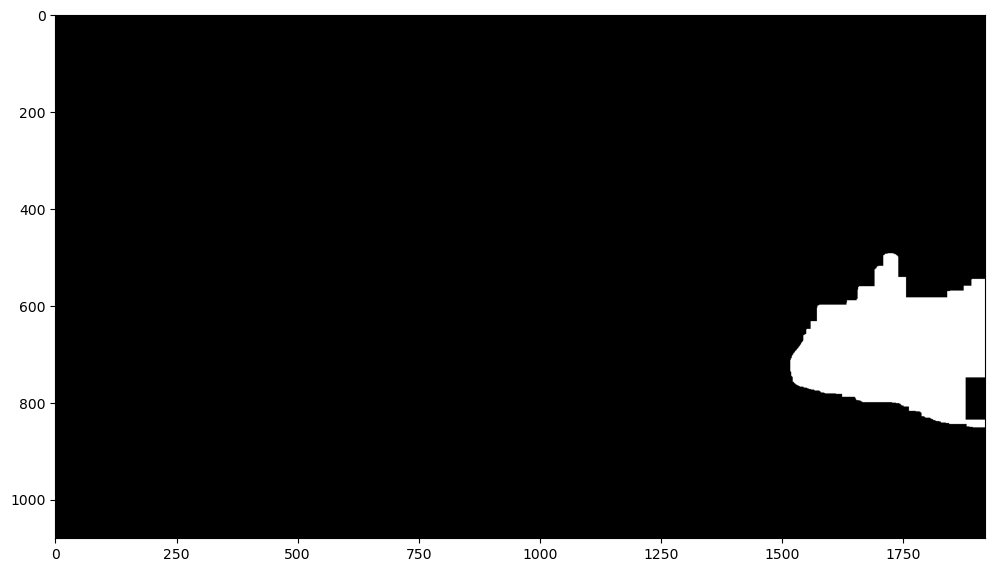

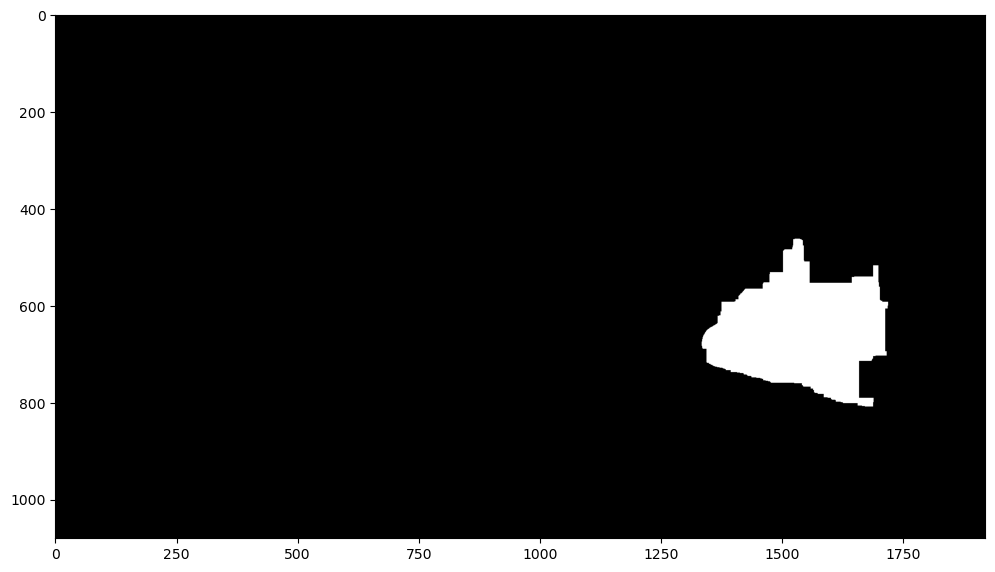

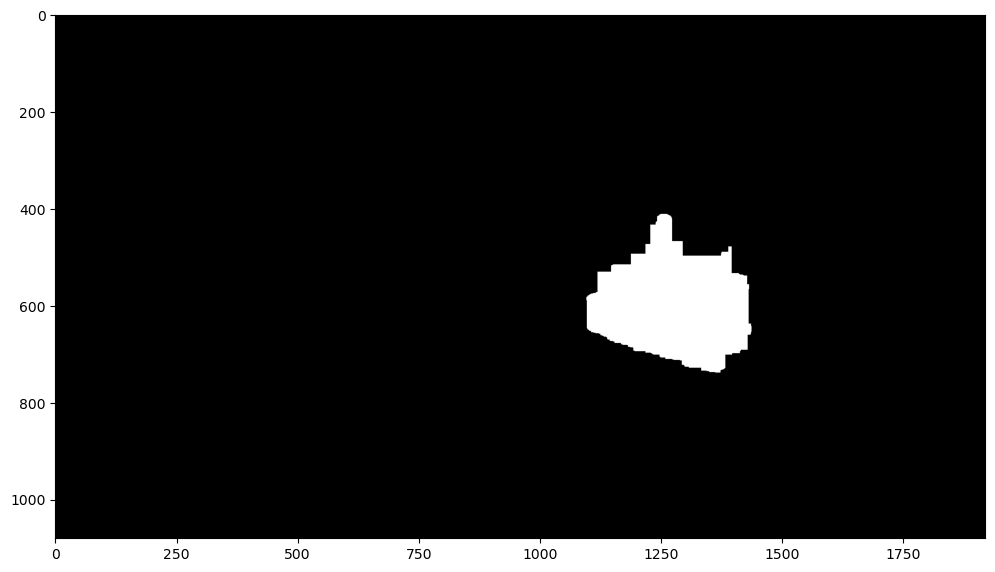

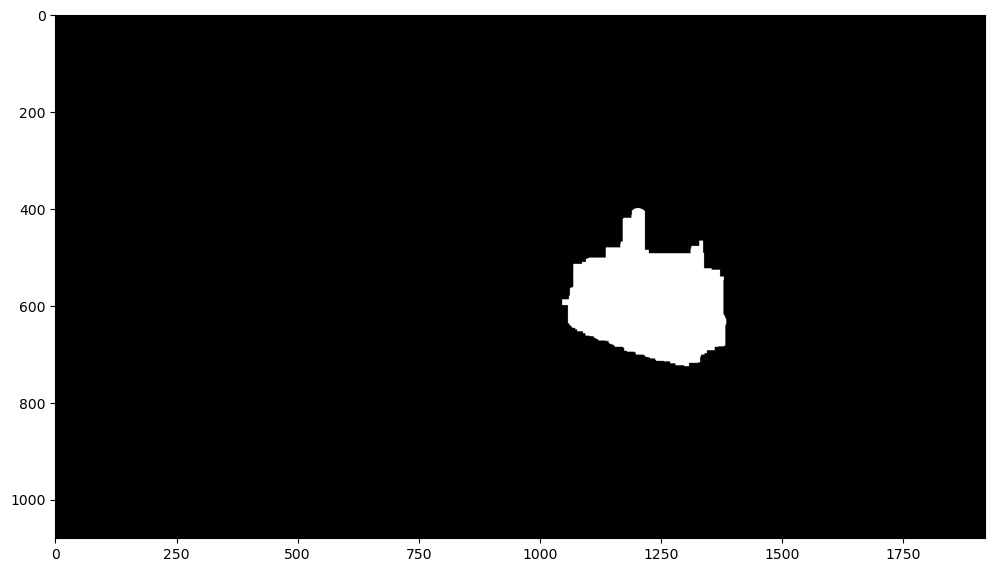

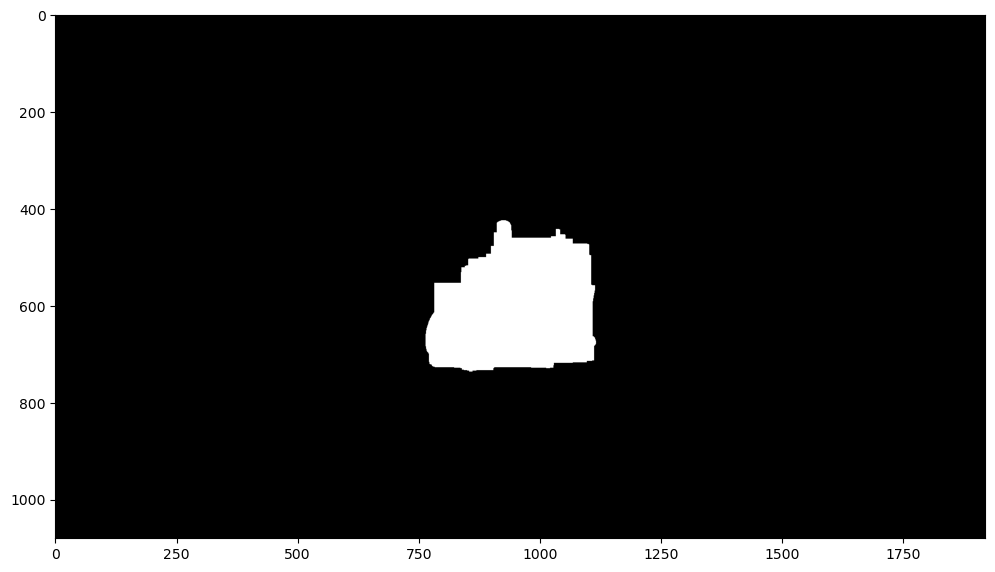

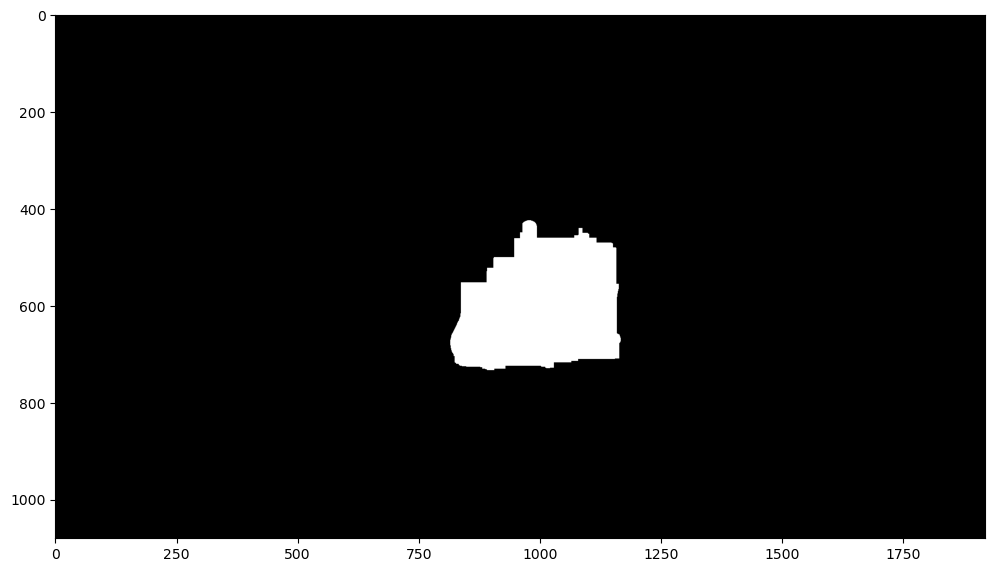

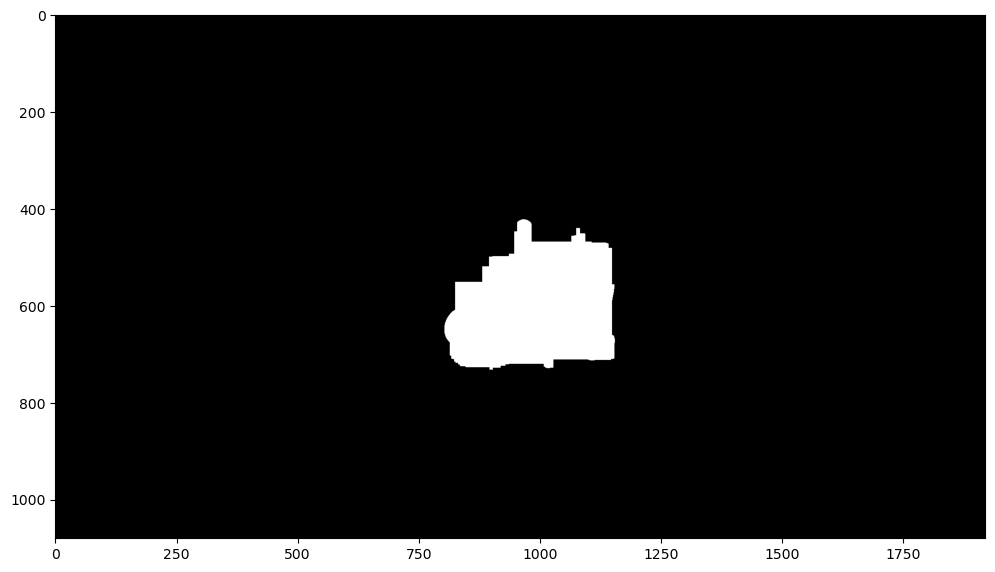

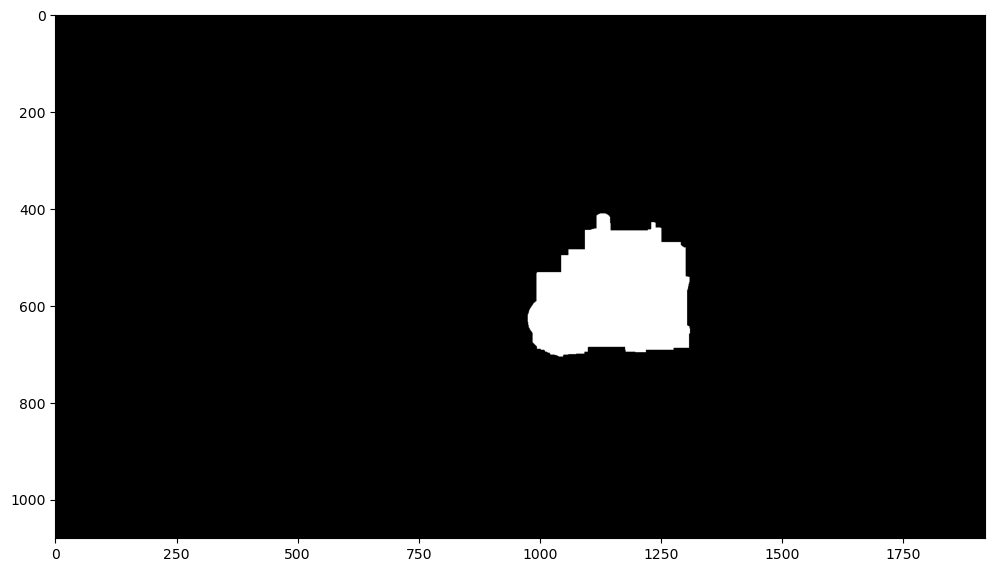

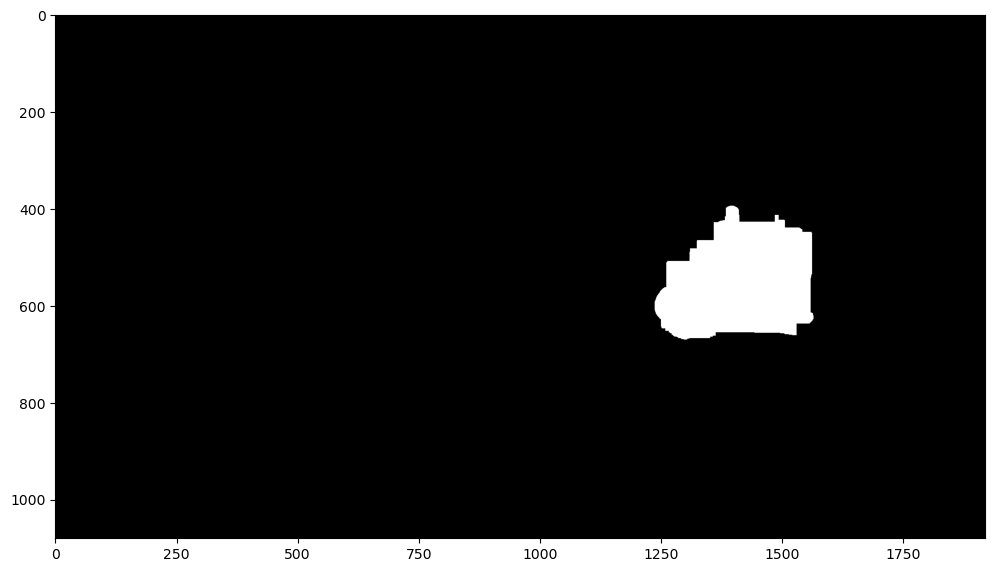

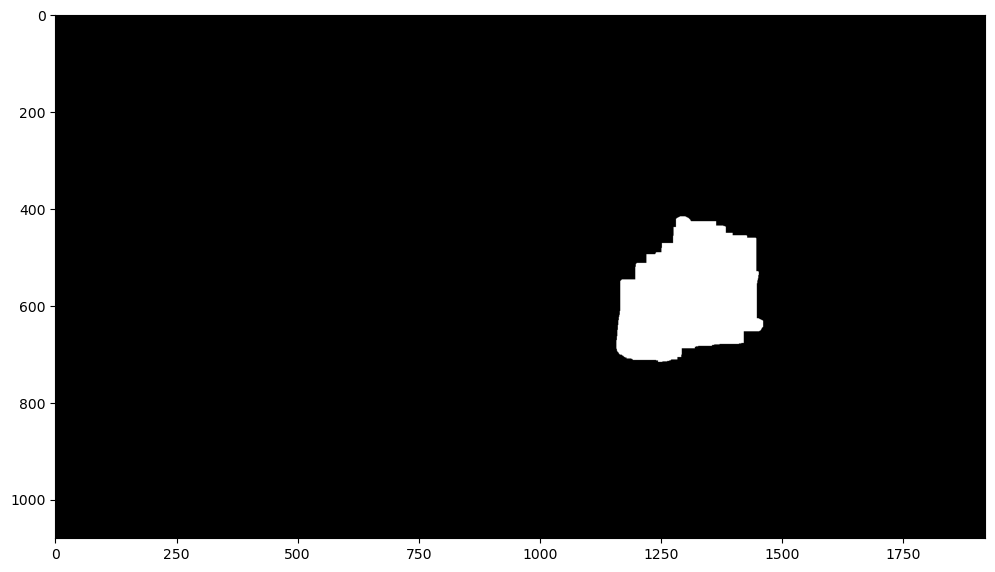

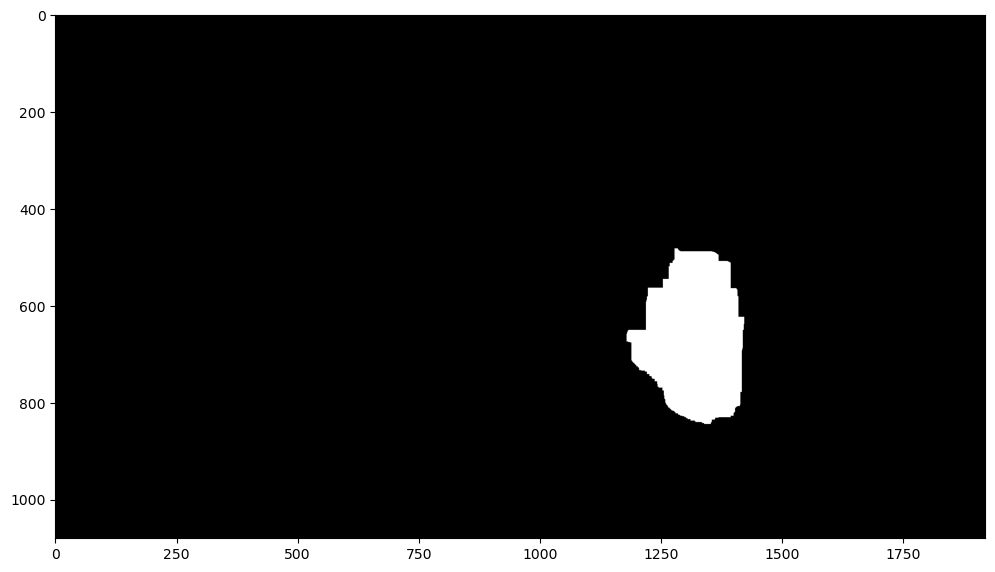

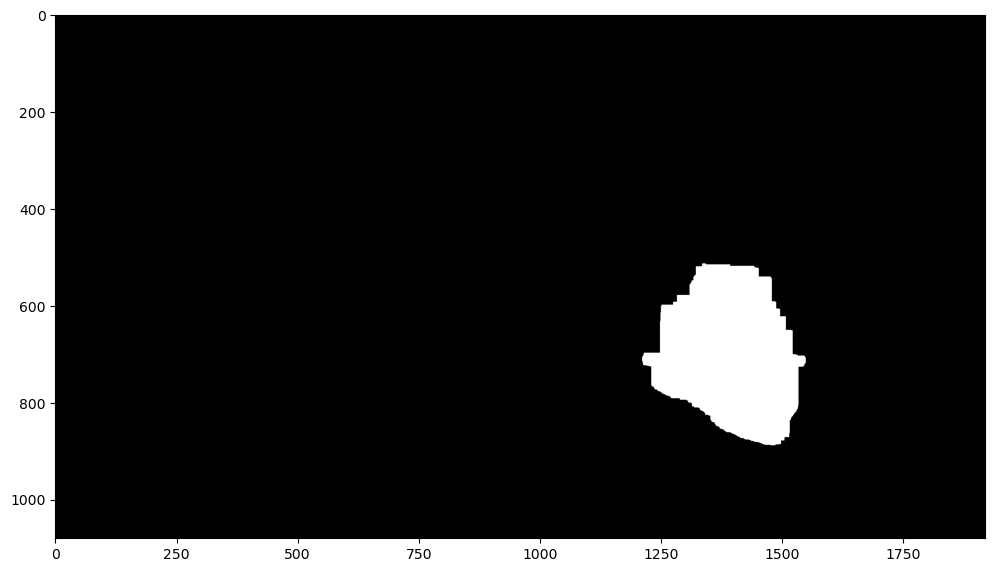

In [6]:
traj_X = []
traj_Y = []
for i in img:
    Cent = Img_Proc(i,50, kernel_o, kernel_c, show_close = True, show_mask = False, save_lim = True )
    traj_X.append(Cent[0])
    traj_Y.append(Cent[1])

#### Path Determination - Limiarized Centroid

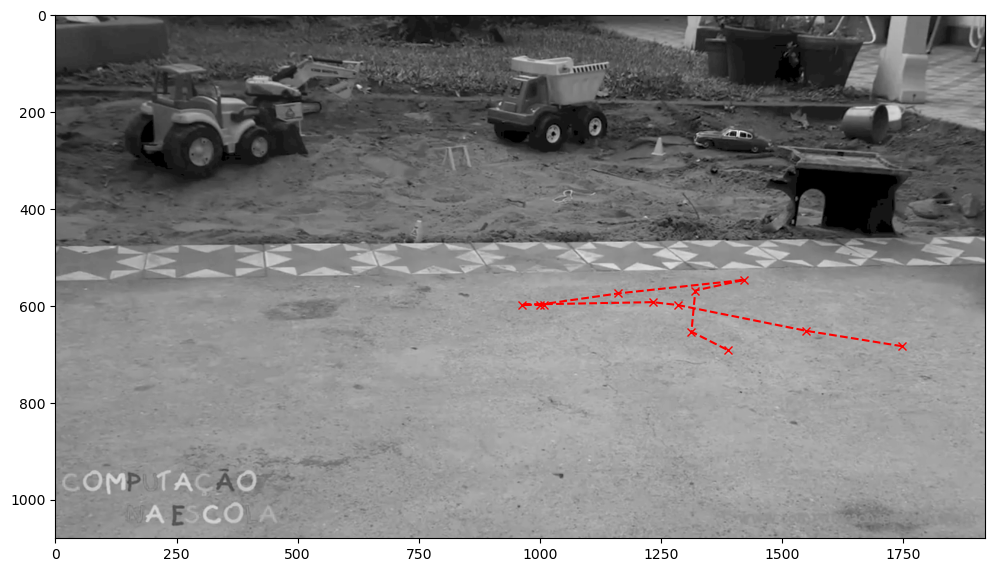

In [8]:
plt.figure(figsize = (12,10))
plt.imshow(ref_gray, 'gray')
plt.plot(traj_X,traj_Y,'rx--')

## Edge Detector

In [9]:
## Limizarized images
img_lim = os.listdir("data/lim")
img_or = img_lim[0]
image = cv2.imread("data/lim/" + img_or, cv2.IMREAD_GRAYSCALE)

#### Testing diferent edge detectors

In [10]:
# Roberts
edge_roberts = roberts(image)

# Sobel
edge_sobel = sobel(image)

# Scharr
edge_scharr = scharr(image)

# Prewitt
edge_prewitt = prewitt(image)

### Ploting the results

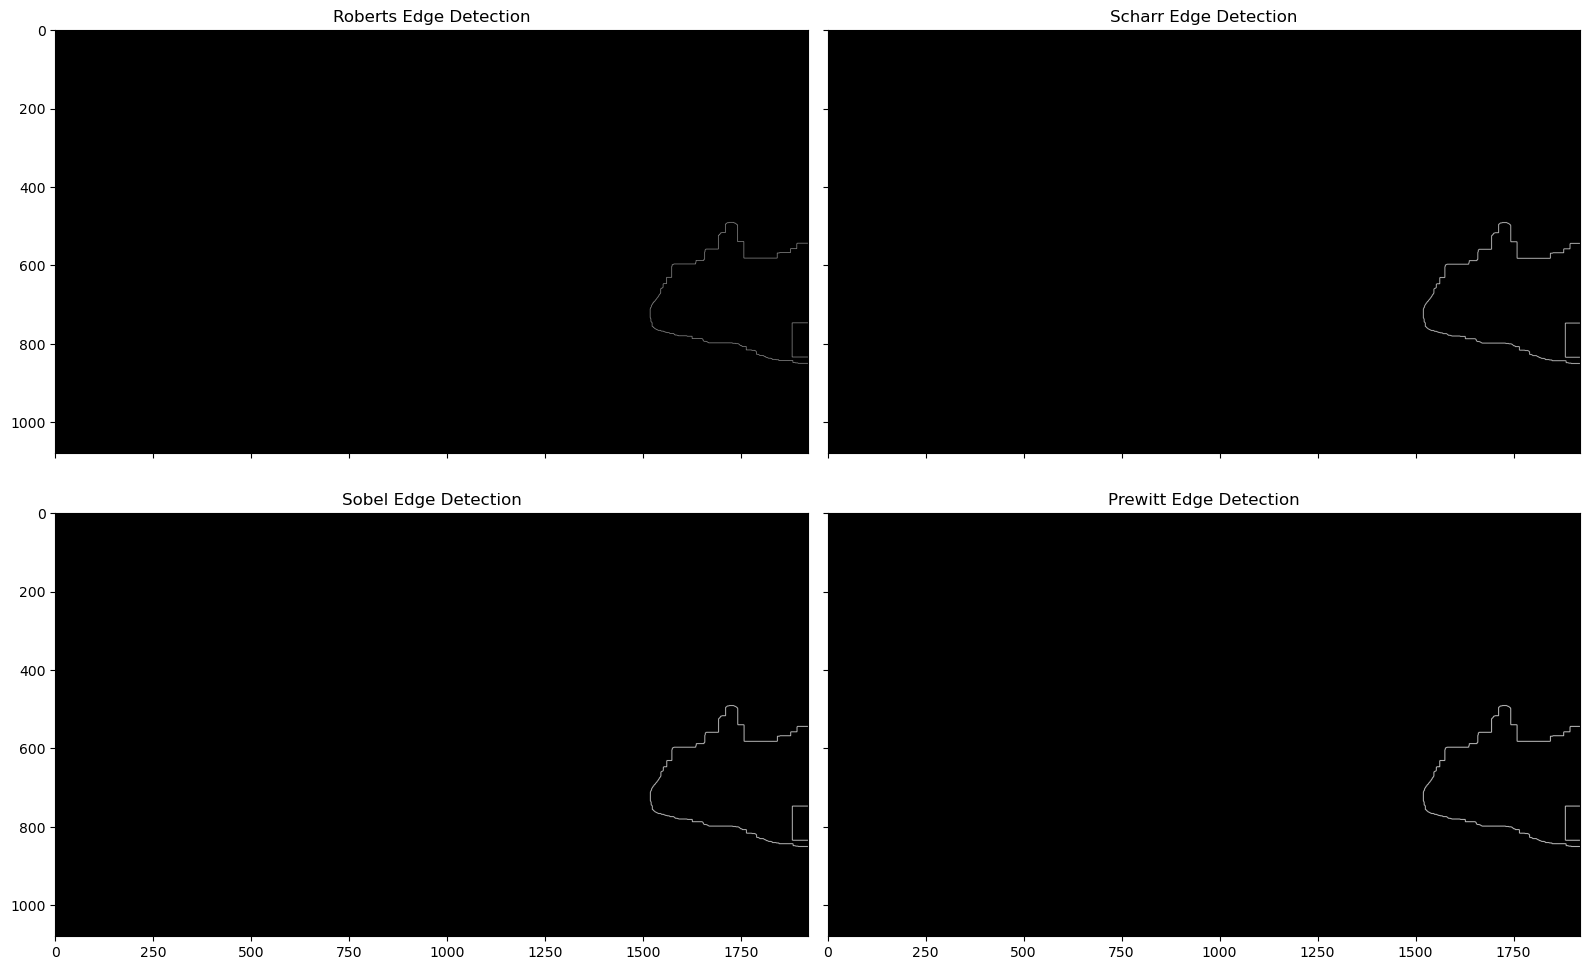

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(16, 10))

ax[0,0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0,0].set_title('Roberts Edge Detection')

ax[1,0].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1,0].set_title('Sobel Edge Detection')

ax[0,1].imshow(edge_scharr, cmap=plt.cm.gray)
ax[0,1].set_title('Scharr Edge Detection')

ax[1,1].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[1,1].set_title('Prewitt Edge Detection')

plt.tight_layout()
plt.show()

### Canny edge detector

In [12]:
def to_gray(image):
     # If the image is colored, make a grayscale copy
    if image.shape[-1] == 3:           
        b,g,r = cv2.split(image)       # get b,g,r
        rgb_img = cv2.merge([r,g,b])     # switch it to rgb
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = image
    return gray_img      

In [13]:
def cannySciKit(image, sigma, low_threshold, high_threshold, use_quantiles = False):
    # Line finding using the Probabilistic Hough Transform
    #image = eval(source)
    gray_img = to_gray(image)

    edges = canny(gray_img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, use_quantiles=use_quantiles)

    # Generating figure 2
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, 'gray')
    ax[0].set_title('Input image')

    ax[1].imshow(edges, cmap=cm.gray)
    ax[1].set_title('Canny edges')

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()
    
    return edges

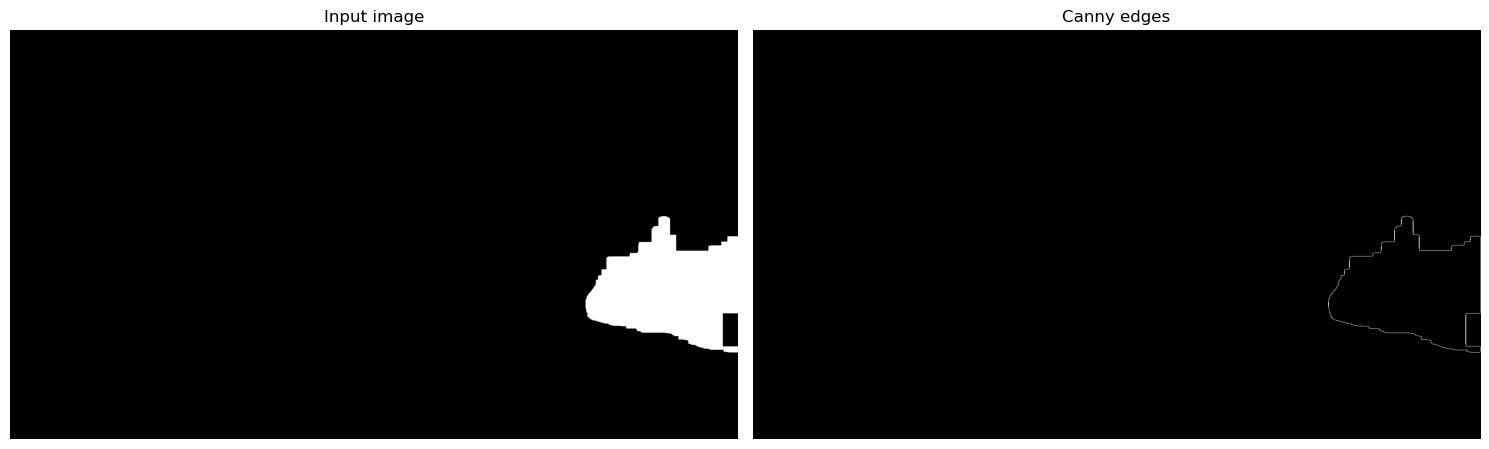

In [14]:
edges = cannySciKit(image, 1, 1, 25)

### Applying the edge detectors in the original images

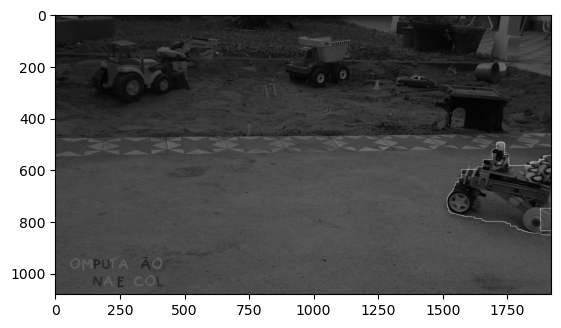

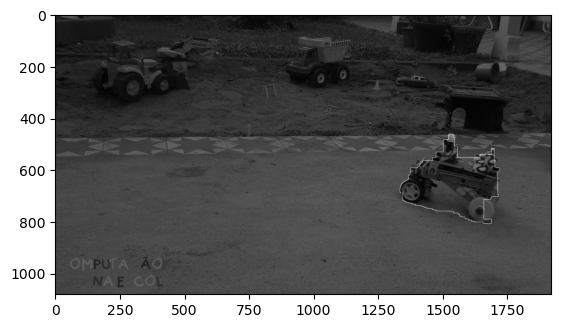

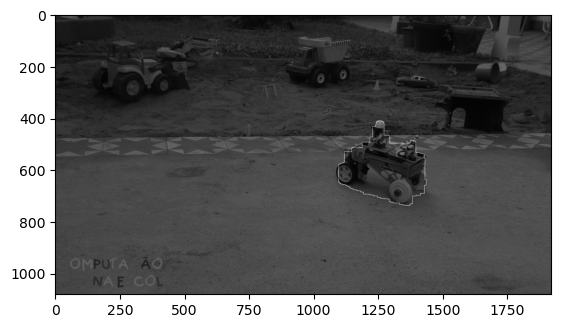

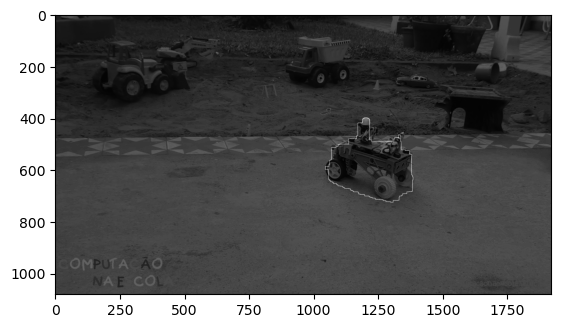

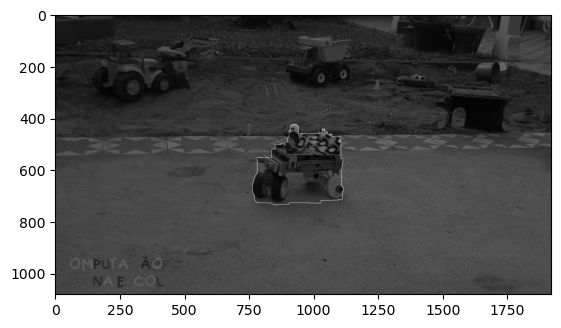

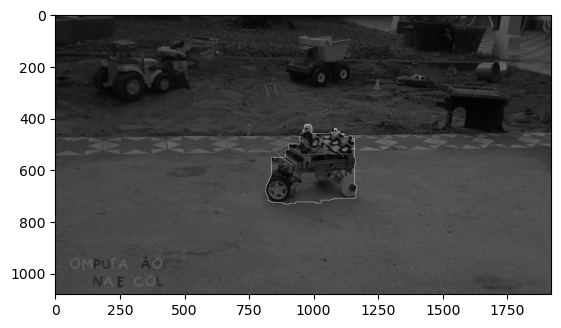

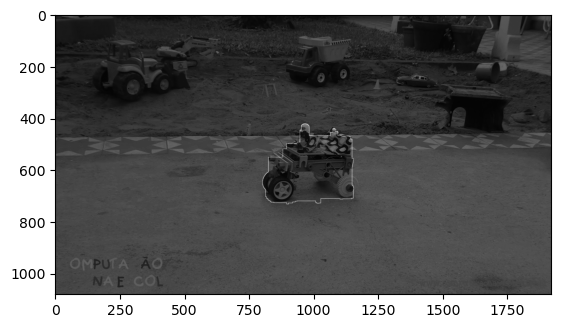

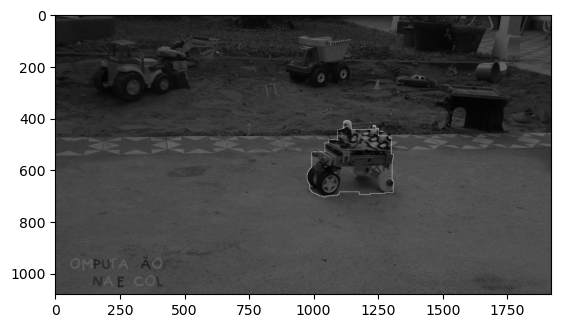

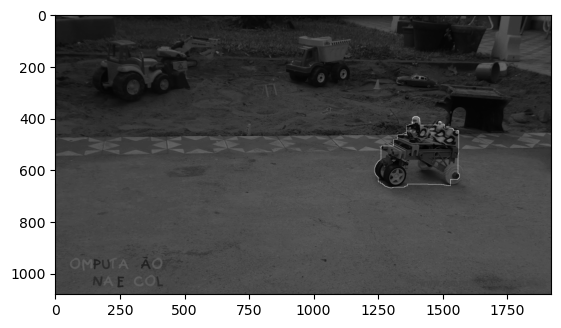

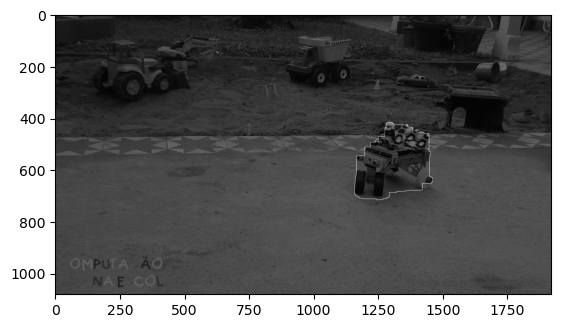

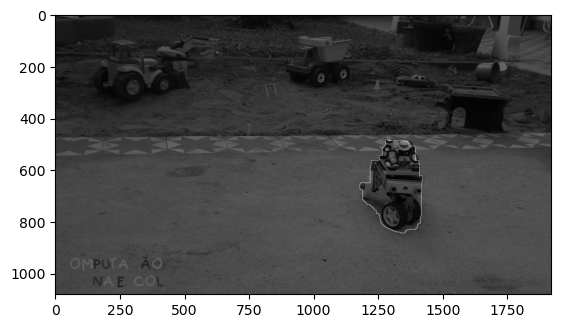

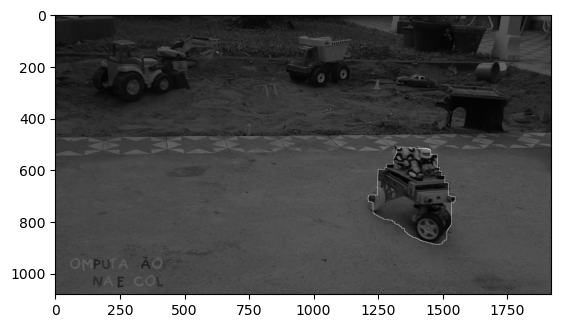

In [15]:
for i,j in enumerate(img):
    
    image_gray = cv2.imread("data/im/" + j, cv2.IMREAD_GRAYSCALE)
    image_lim = cv2.imread("data/lim/" + img_lim[i], cv2.IMREAD_GRAYSCALE)
    edge_sobel = sobel(image_lim)
    edge_sobel[edge_sobel > 0] = 255
    plt.imsave('data/edge/' + j + '_lim.png', edge_sobel, cmap='gray')
    res = image_gray + edge_sobel
    plt.imshow(res, cmap=cm.gray)
    plt.show()

### Applying the edge detectors in the original initial image

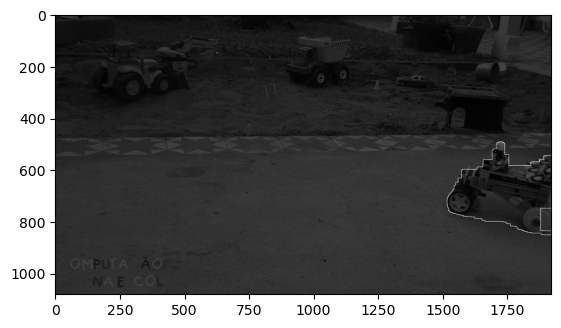

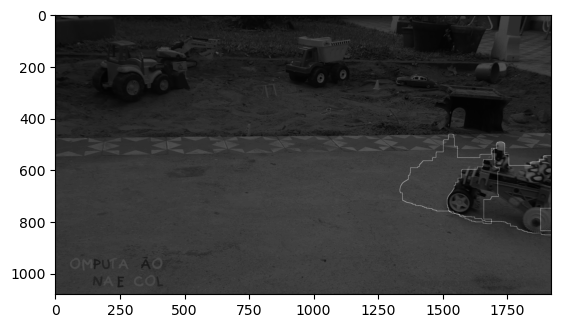

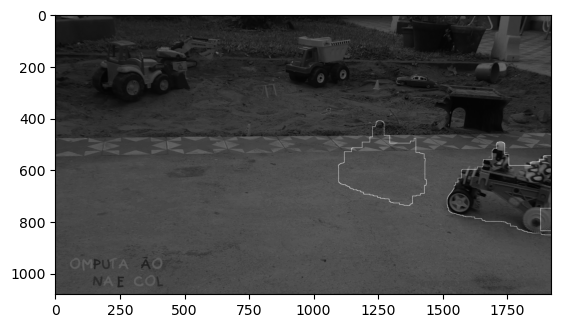

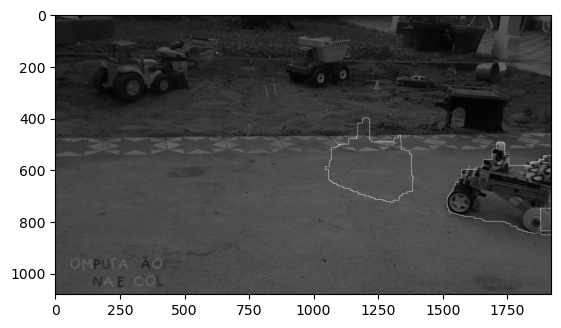

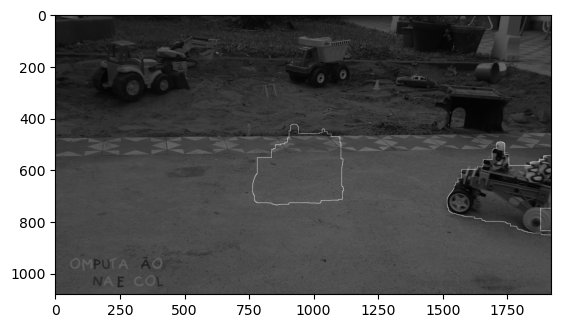

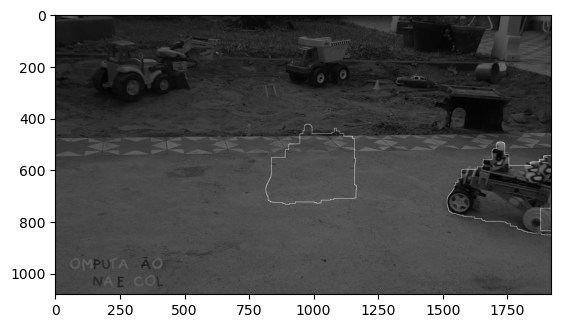

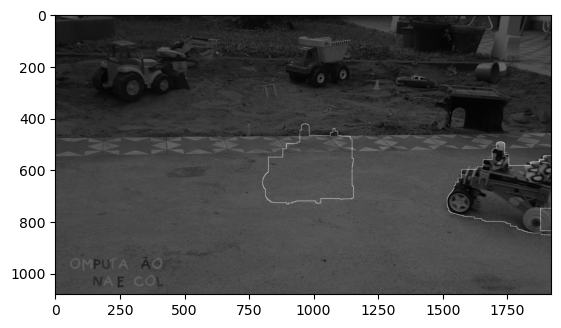

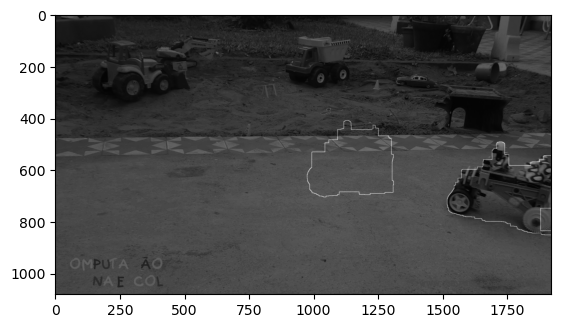

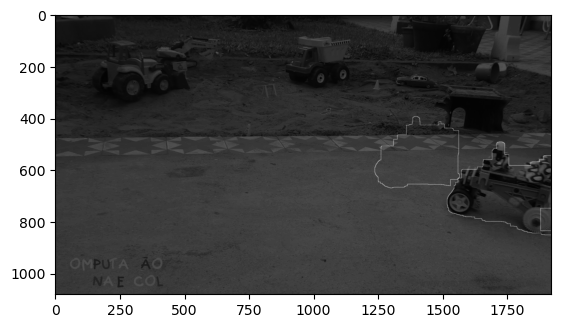

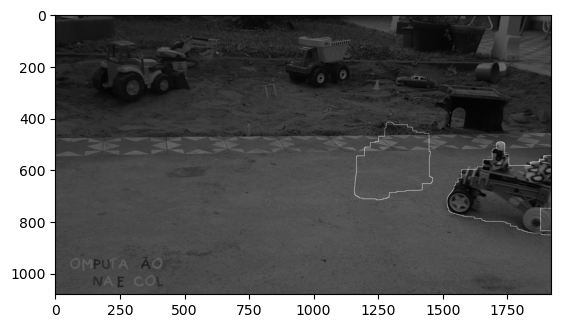

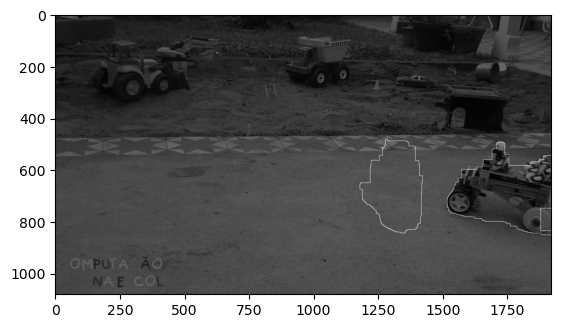

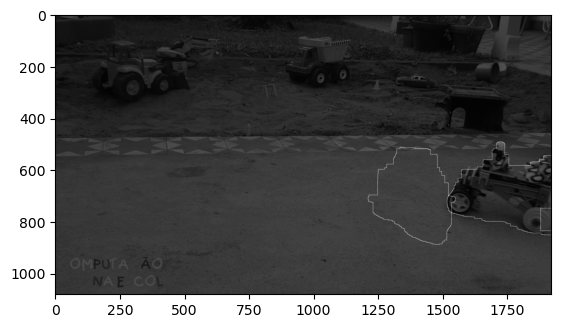

In [16]:
image_gray = cv2.imread("data/im/" + img[0], cv2.IMREAD_GRAYSCALE)
image_lim_0 = cv2.imread("data/lim/" + img_lim[0], cv2.IMREAD_GRAYSCALE)
edge_sobel_0 = sobel(image_lim_0)
edge_sobel_0[edge_sobel_0 > 0] = 255


for i in img_lim:

    image_lim = cv2.imread("data/lim/" + i, cv2.IMREAD_GRAYSCALE)
    edge_sobel = sobel(image_lim)
    edge_sobel[edge_sobel > 0] = 255
    res = image_gray + edge_sobel + edge_sobel_0
    plt.imshow(res, cmap=cm.gray)
    plt.show()

## Convex Hull

#### Convex Hull and Limiarized images

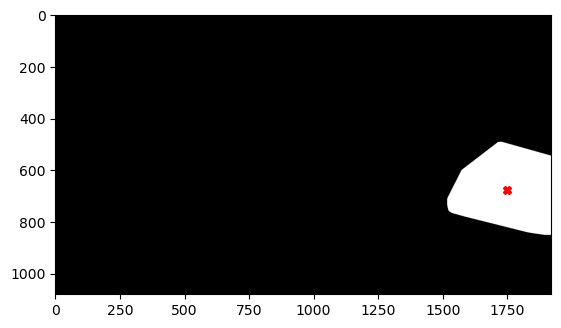

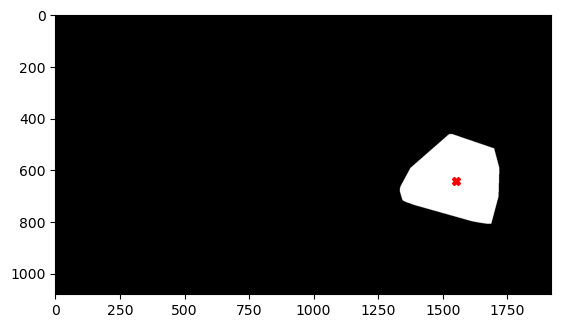

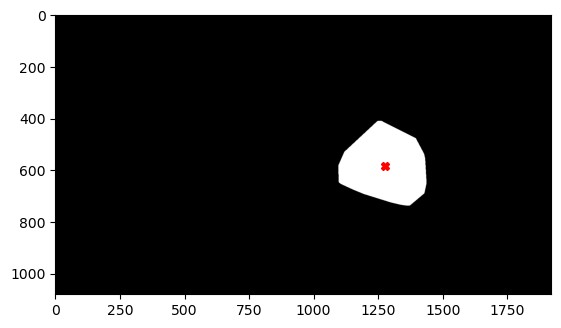

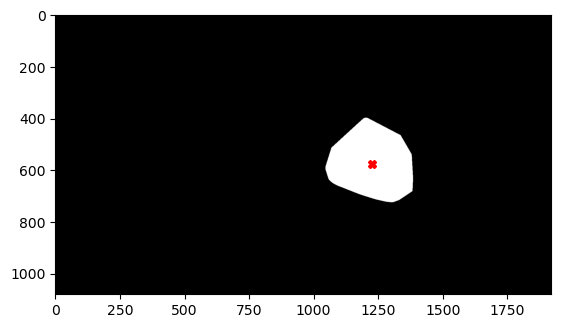

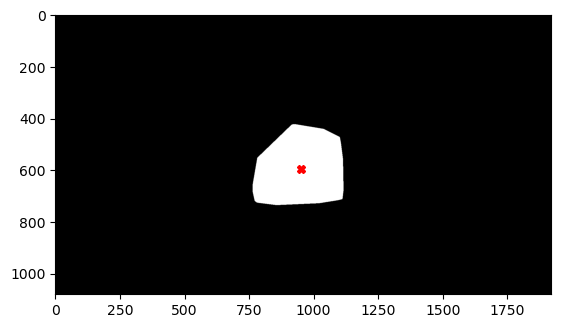

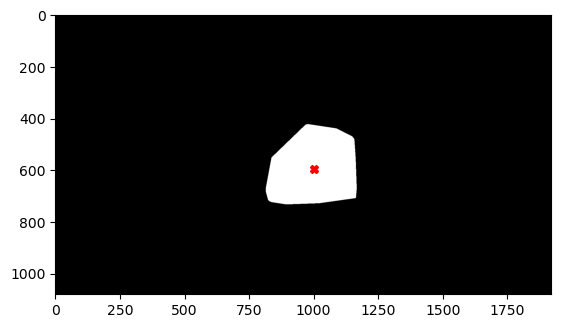

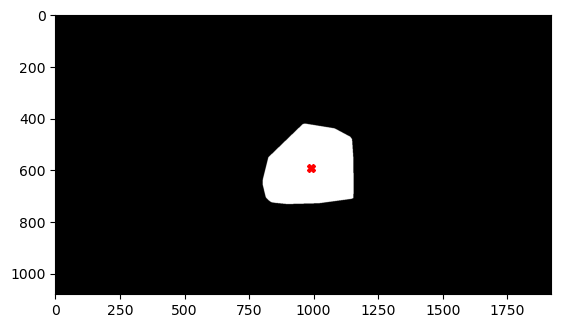

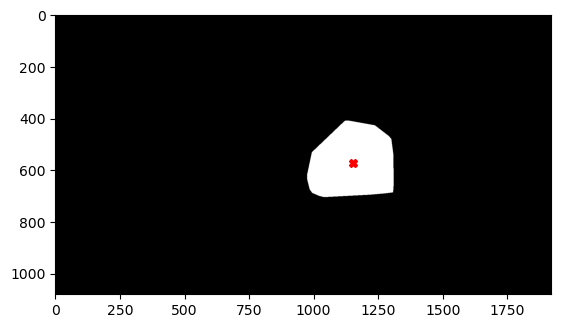

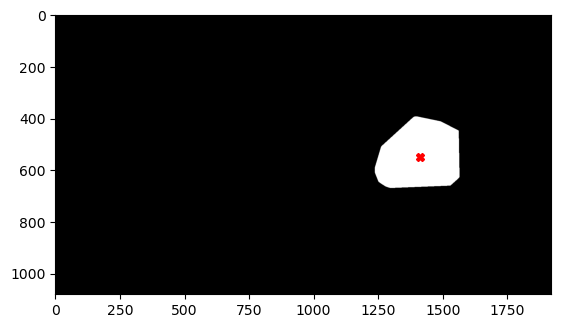

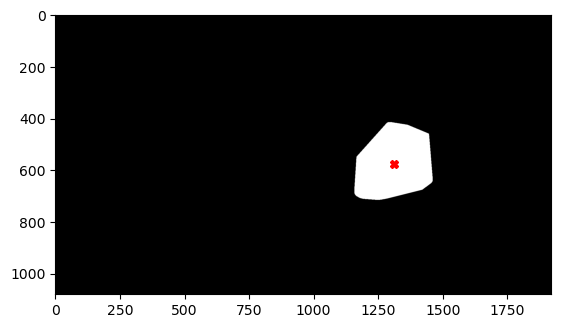

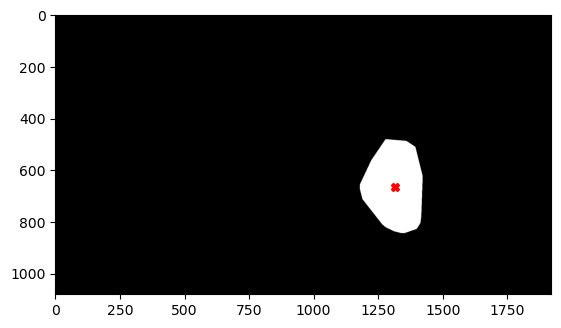

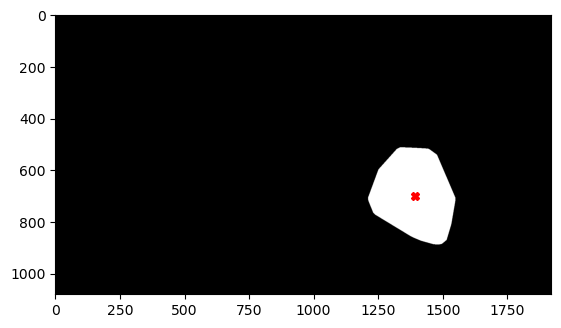

In [18]:
traj_X_ch1 = []
traj_Y_ch1 = []

for i in img_lim:
    image_lim = cv2.imread("data/lim/" + i, cv2.IMREAD_GRAYSCALE)
    hull = convex_hull_image(image_lim)
    
    traj_X_ch1.append(measure.centroid(hull)[1])
    traj_Y_ch1.append(measure.centroid(hull)[0])
    
    plt.imshow(hull, cmap=cm.gray)
    plt.plot(measure.centroid(hull)[1],measure.centroid(hull)[0],'rX')
    plt.show()

#### Convex Hull and Edge Detector

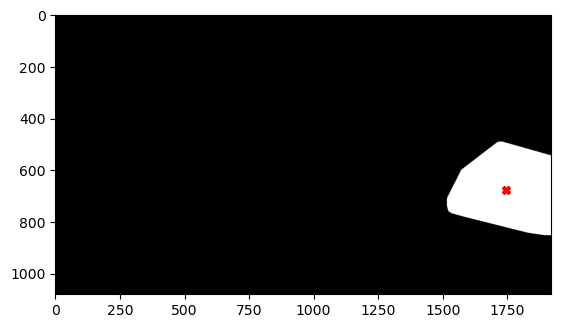

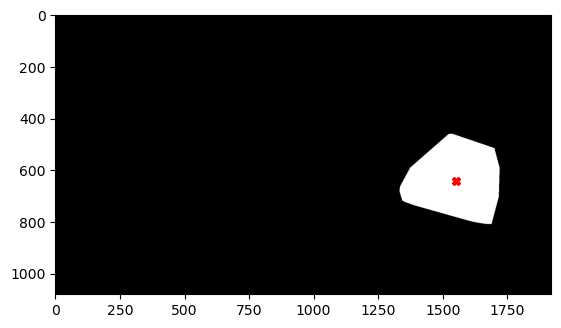

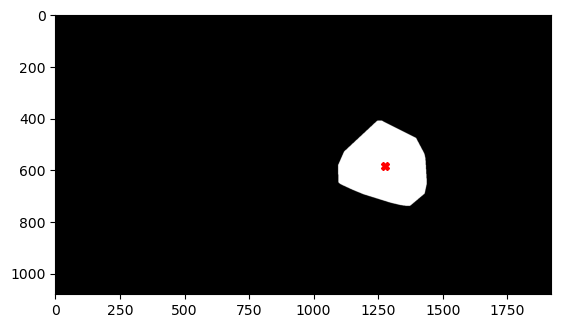

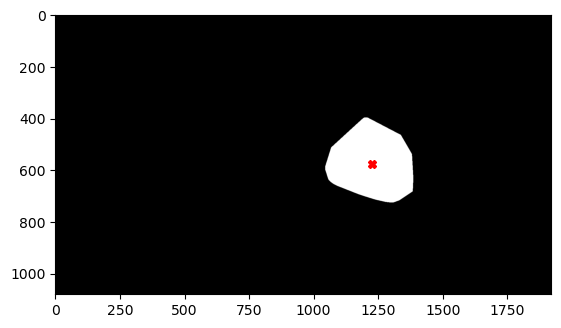

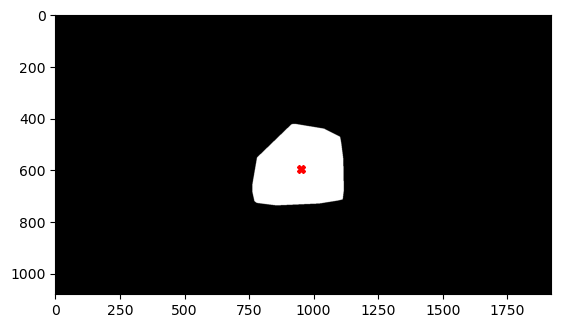

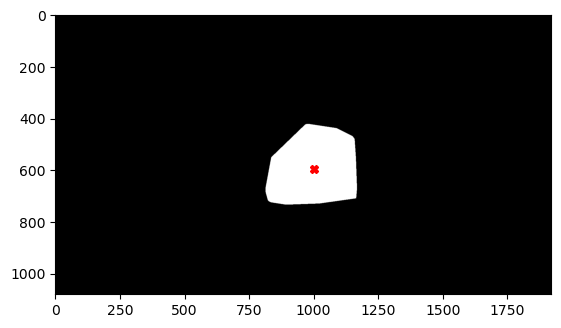

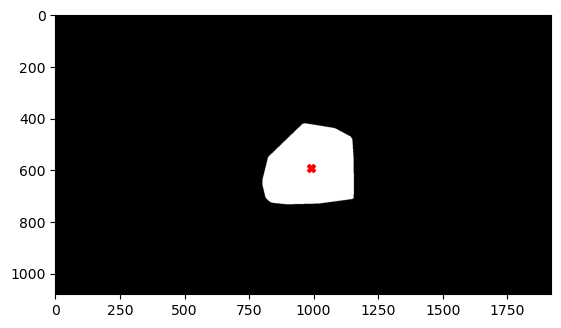

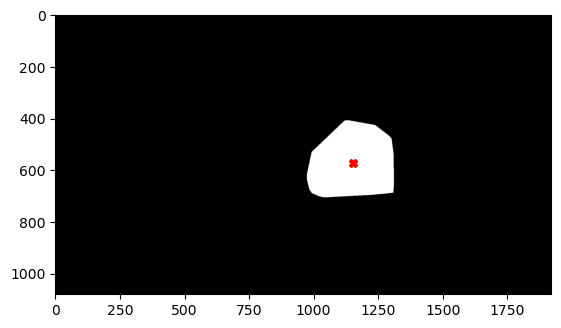

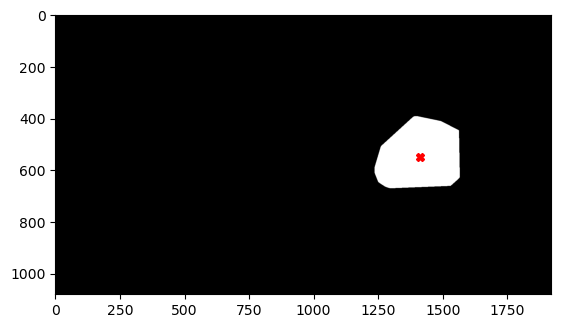

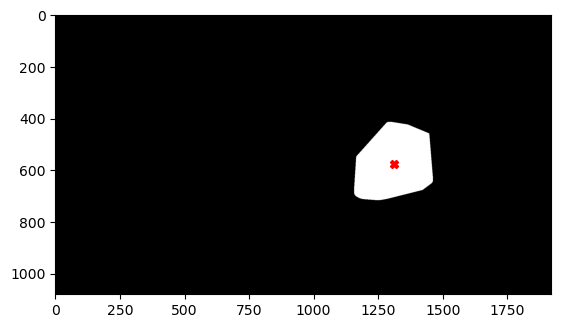

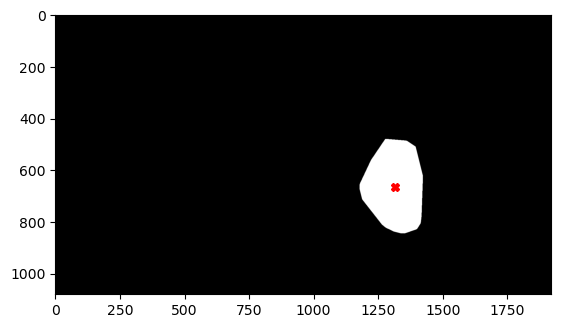

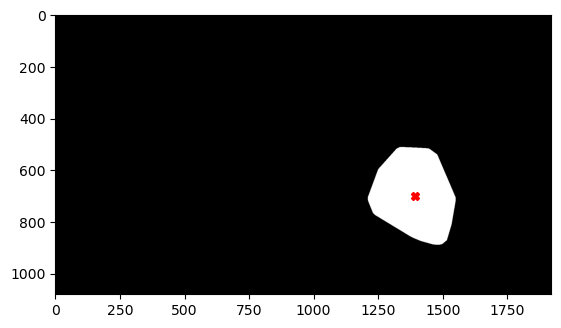

In [19]:
img_edge = os.listdir("data/edge")

traj_X_ch2 = []
traj_Y_ch2 = []

for i in img_edge:
    image_lim = cv2.imread("data/edge/" + i, cv2.IMREAD_GRAYSCALE)
    hull = convex_hull_image(image_lim)
    
    
    traj_X_ch2.append(measure.centroid(hull)[1])
    traj_Y_ch2.append(measure.centroid(hull)[0])
    
    plt.plot(measure.centroid(hull)[1],measure.centroid(hull)[0],'rX')
    plt.imshow(hull, cmap=cm.gray)
    plt.show()

## Bounding Rectangle

#### Bounding rectangles and limiarized images

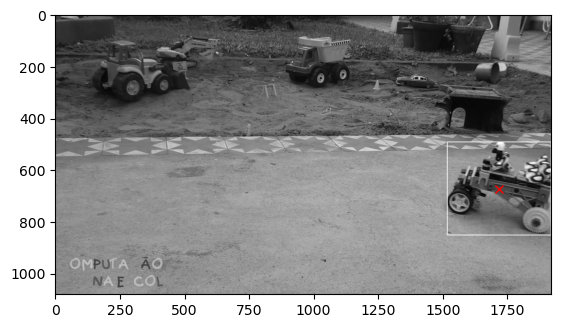

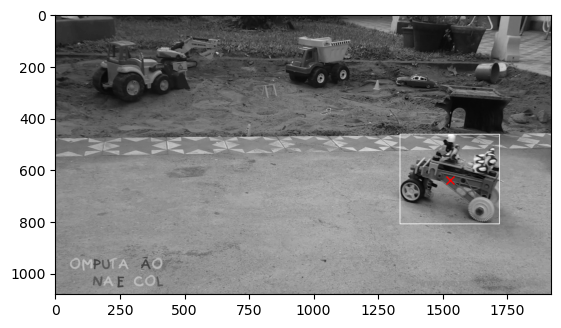

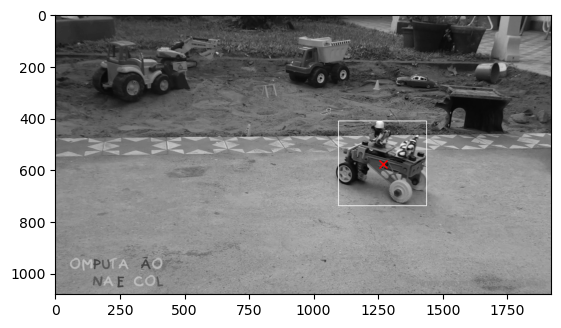

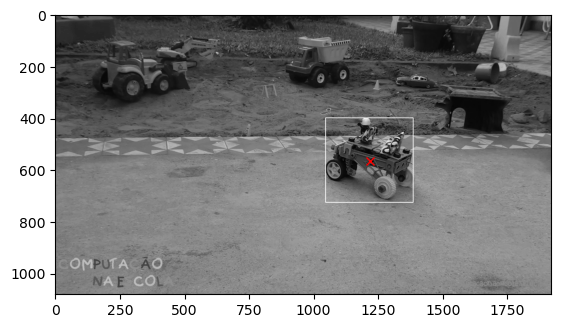

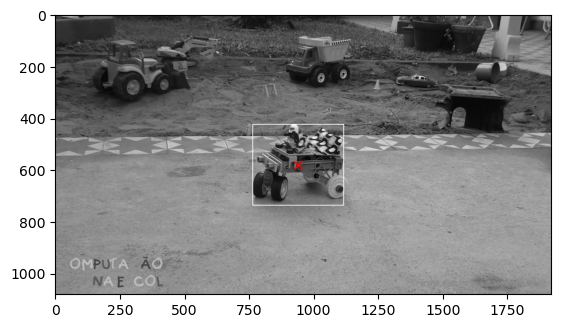

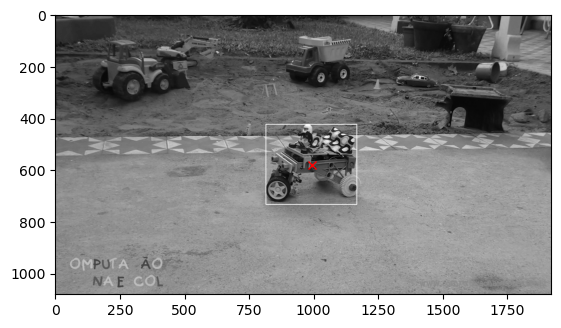

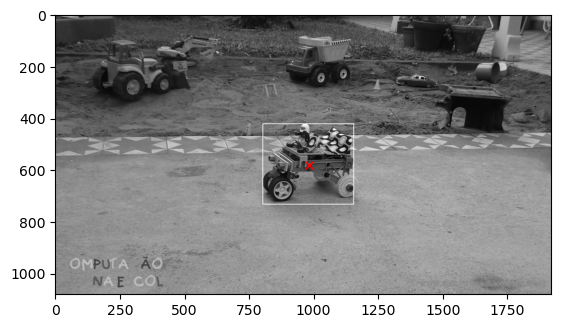

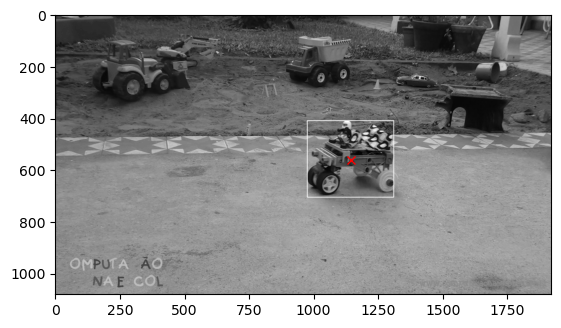

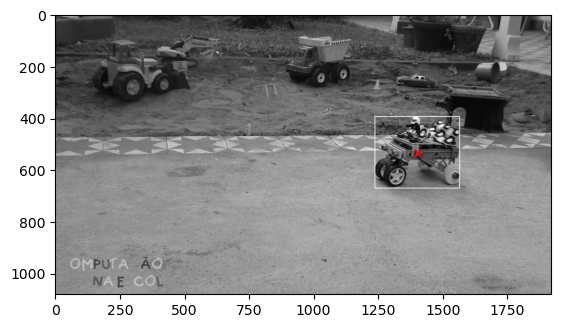

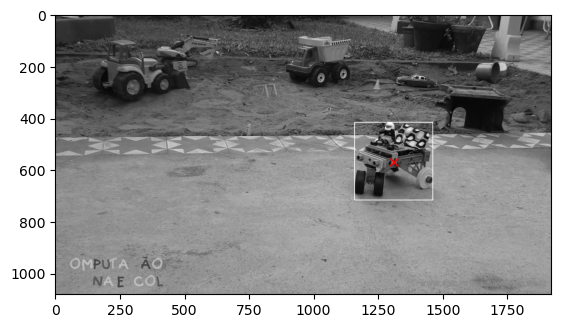

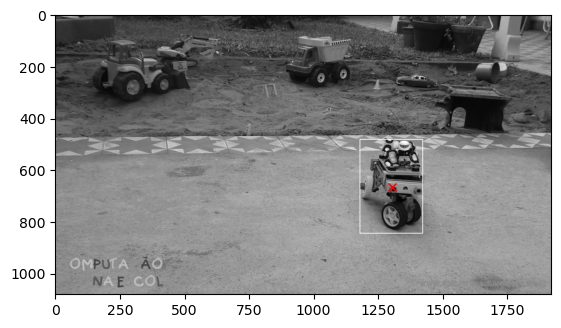

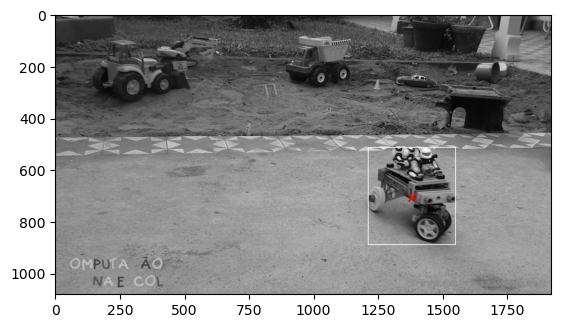

In [20]:
traj_X_bb = []
traj_Y_bb = []


for i,j in enumerate(img):
    
    image_gray = cv2.imread("data/im/" + j, cv2.IMREAD_GRAYSCALE)
    image_lim = cv2.imread("data/lim/" + img_lim[i], cv2.IMREAD_GRAYSCALE)
    
    x,y,w,h = cv2.boundingRect(image_lim)
    cv2.rectangle(image_gray,(x,y),(x+w,y+h),(255,255,255),2)
    
    traj_X_bb.append(x + w/2)
    traj_Y_bb.append(y + h/2)
    
    plt.imshow(image_gray, cmap=cm.gray)
    plt.plot(x + w/2, y + h/2, 'rx')
    plt.show()

## Path comparisson

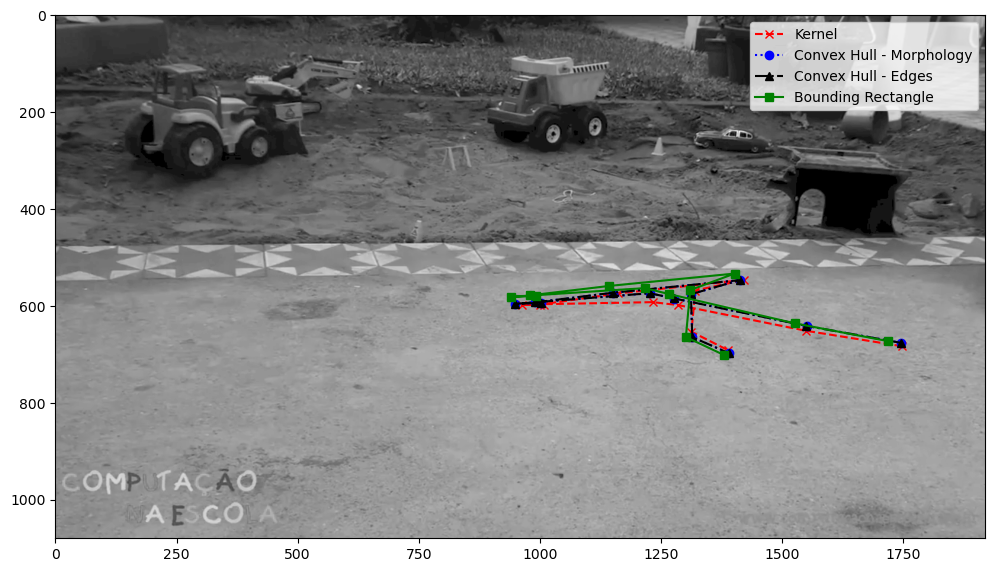

In [21]:
plt.figure(figsize = (12,10))
plt.imshow(ref_gray, 'gray')
plt.plot(traj_X,traj_Y,'rx--',label = 'Kernel')
plt.plot(traj_X_ch1,traj_Y_ch1,'bo:', label = 'Convex Hull - Morphology')
plt.plot(traj_X_ch2,traj_Y_ch2,'k^-.', label = 'Convex Hull - Edges')
plt.plot(traj_X_bb,traj_Y_bb,'gs-', label = 'Bounding Rectangle')
plt.legend()